In [93]:
import csv

In [108]:
def get_characters_bin(match_str):
    # This is the separator between the character codes and the match datetime: 0x95 0xB2
    # However sometimes it can appear multiple times because some other data is coincidentally set to the same values
    # Those cases are very rare however approx 3 in 80000
    index = match_str.index(b'\x95\xb2')
    raw_bytes = match_str[index-2:index]
    char_codes = [int(x) for x in raw_bytes]
    if max(char_codes) > 16:
        raise Exception('TOO MANY MATCHES',match_str.count(b'\x95\xb2'),match_str)
    return char_codes

def get_winner_bin(match_str):
    raw_bytes = int(match_str[-1])
    return raw_bytes

def get_date_bin(match_str):
    return match_str[:14].decode()

def get_match_data_bin(match_str):
    data = get_characters_bin(match_str)
    data.append(get_winner_bin(match_str))
    data.insert(0,get_date_bin(match_str))
    
    return data

In [161]:
with open('replaysRAW.txt', "rb") as f:
    data = f.read()
    # When writing the files from the modified totsugeki.exe we use a sequence of 8 0xF2 as a delimiter between calls
    bin_matches = data.split(b'\xf2\xf2\xf2\xf2\xf2\xf2\xf2\xf2')


match_list = []
# page here denotes a set of games when scrolling through the replays list
for page in bin_matches:
    match_str_list = page.split(b'\xb32021\x2d')
    # The first and last match strings are not formatted the same as the rest
    # I think they might contain metadata about the request
    # TODO: Isolate and investigate what exactly that is
    for match_str in match_str_list[1:-1]:
        try:
            match_list.append(get_match_data_bin(match_str))
        except Exception as e:
            print(e, [x for x in match_str])

('TOO MANY MATCHES', 3, b'08-25 13:39:05\x01\x00\x00\x00\x9d\xcf\x02\xed\x00W\x9f\xfc\x95\xb2\x04c\x01\t\x95\xb2210611111827413911\xa4KANA\xb176561198170240478\xaf11000010c83f5de\t\x95\xb2210611115822351998\xa4sudo\xb176561198166139888\xaf11000010c4563f0\t\x01') [48, 56, 45, 50, 53, 32, 49, 51, 58, 51, 57, 58, 48, 53, 1, 0, 0, 0, 157, 207, 2, 237, 0, 87, 159, 252, 149, 178, 4, 99, 1, 9, 149, 178, 50, 49, 48, 54, 49, 49, 49, 49, 49, 56, 50, 55, 52, 49, 51, 57, 49, 49, 164, 75, 65, 78, 65, 177, 55, 54, 53, 54, 49, 49, 57, 56, 49, 55, 48, 50, 52, 48, 52, 55, 56, 175, 49, 49, 48, 48, 48, 48, 49, 48, 99, 56, 51, 102, 53, 100, 101, 9, 149, 178, 50, 49, 48, 54, 49, 49, 49, 49, 53, 56, 50, 50, 51, 53, 49, 57, 57, 56, 164, 115, 117, 100, 111, 177, 55, 54, 53, 54, 49, 49, 57, 56, 49, 54, 54, 49, 51, 57, 56, 56, 56, 175, 49, 49, 48, 48, 48, 48, 49, 48, 99, 52, 53, 54, 51, 102, 48, 9, 1]
('TOO MANY MATCHES', 3, b'08-25 06:50:11\x01\x00\x00\x00\x9d\xcf\x02\xed\x00G\x95\xb2\x07!\x04c\x0b\x00\x95\xb2

In [141]:
with open('GGST_Replays.csv', 'w') as f:
    fields  = ['date','p1CharCode','p2CharCode', 'winner']
    writer = csv.writer(f)
    writer.writerow(fields)
    writer.writerows(match_list)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
LOCAL_TIMEZONE = datetime.datetime.now().astimezone().tzinfo

In [3]:
df =pd.read_csv('GGST_Replays.csv')

In [4]:
df.head()

,date,p1CharCode,p2CharCode,winner
0,08-25 17:33:56,11,11,1
1,08-25 17:33:40,11,11,1
2,08-25 17:33:05,11,11,1
3,08-25 17:31:54,11,11,1
4,08-25 17:30:28,14,4,1


In [5]:
df.shape

(81029, 4)

In [6]:
print('data was collected between', df['date'].min(), 'and', df['date'].max()) 

data was collected between 08-24 05:29:50 and 08-25 20:45:59


In [7]:
def convert_to_datetime(api_date):
    return np.datetime64('2021-'+api_date)

# TODO:  fix this
def convert_to_hours_and_mins(api_date):
    return np.datetime64(api_date[6:].replace(':','-'))

# convert_to_hours_and_mins(df['date'][0])
df['date'] = df['date'].apply(convert_to_datetime)


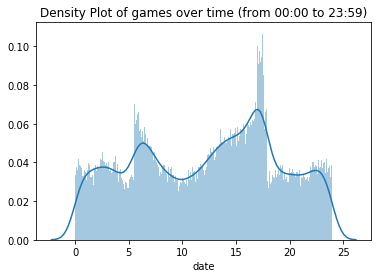

In [8]:
# NOTE: these times are from the timezone where the data was collected
# in my case this is UTC+2
time_of_day = pd.DatetimeIndex(df['date']).hour + pd.DatetimeIndex(df['date']).minute/60
plt.title('Density Plot of games over time (from 00:00 to 23:59)')
plt.show(sns.distplot(time_of_day , bins=24*30))

In [9]:
readable_character_names = ['sol', 'ky', 'may', 'axl', 'chipp', 'potemkin', 'faust', 'millia', 'zato', 'ramlethal', 'leo', 'nagoriyuki', 'giovanna', 'anji', 'i-no', 'goldlewis']
chars, counts = np.unique(df[['p1CharCode','p2CharCode']].to_numpy(), return_counts=True)

In [10]:
wins = np.zeros(16)
losses = np.zeros(16)
matchup_wins = np.zeros((16,16))
matchup_losses = np.zeros((16,16))
for index, row in df.iterrows():
    try:
        winner = row['p1CharCode'] if row['winner'] == 1 else row['p2CharCode']
        loser  = row['p1CharCode'] if row['winner'] == 2 else row['p2CharCode']
        wins[winner] += 1
        losses[loser] += 1
        matchup_wins[winner][loser] += 1
        matchup_losses[loser][winner] += 1
    except:
        pass

In [11]:
total_games = (wins+losses)
winrate = wins/total_games

matchup_totals = matchup_wins+matchup_losses
matchup_table = matchup_wins/matchup_totals

In [12]:
sorted(list(zip(readable_character_names, np.around(winrate,4), total_games)),key=lambda x : x[1])

[('faust', 0.4522, 4443.0),
 ('millia', 0.4631, 10544.0),
 ('anji', 0.4642, 6990.0),
 ('zato', 0.4693, 6863.0),
 ('ramlethal', 0.4837, 13208.0),
 ('ky', 0.4883, 13762.0),
 ('leo', 0.4917, 8403.0),
 ('giovanna', 0.4921, 10507.0),
 ('i-no', 0.4922, 7021.0),
 ('may', 0.5052, 12842.0),
 ('goldlewis', 0.512, 6642.0),
 ('potemkin', 0.5139, 11577.0),
 ('chipp', 0.514, 8655.0),
 ('sol', 0.519, 14797.0),
 ('nagoriyuki', 0.5353, 16654.0),
 ('axl', 0.5379, 9150.0)]

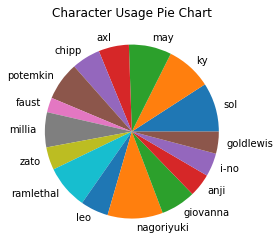

In [13]:
plt.title('Character Usage Pie Chart')
plt.show(plt.pie(total_games, labels=readable_character_names))

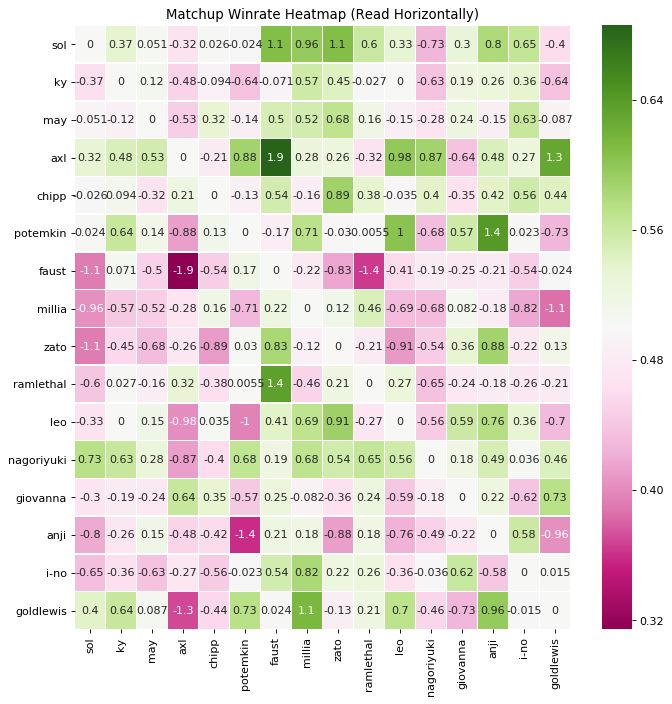

In [14]:
from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)

plt.title('Matchup Winrate Heatmap (Read Horizontally)')
ratios = (matchup_table-0.5)*10
plt.show(sns.heatmap(matchup_table, linewidth=0.5,xticklabels = readable_character_names, yticklabels = readable_character_names, cmap="PiYG", annot=ratios))


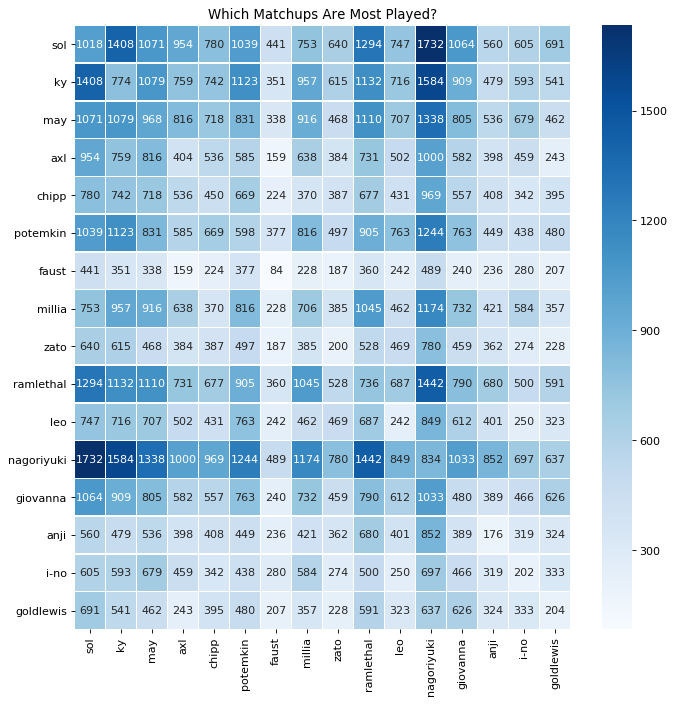

In [15]:
figure(figsize=(10, 10), dpi=80)
annotations = matchup_totals
plt.title('Which Matchups Are Most Played?')
plt.show(sns.heatmap(matchup_totals, linewidth=0.5,xticklabels = readable_character_names, yticklabels = readable_character_names, cmap="Blues",annot=True, fmt='g'))

In [16]:
least_played_matchup = np.unravel_index(np.argmin(matchup_totals, axis=None), matchup_totals.shape)
least_played_matchup_human_readable = [readable_character_names[x] for x in least_played_matchup]
least_played_matchup_value = np.min(matchup_totals)
print('least played matchup is:', least_played_matchup_human_readable, 'with ',least_played_matchup_value, 'games played in total')

least played matchup is: ['faust', 'faust'] with  84.0 games played in total


In [17]:
most_played_matchup = np.unravel_index(np.argmax(matchup_totals, axis=None), matchup_totals.shape)
most_played_matchup_human_readable = [readable_character_names[x] for x in most_played_matchup]
most_played_matchup_value = np.max(matchup_totals)
print('most played matchup is:', most_played_matchup_human_readable, 'with ',most_played_matchup_value, 'games played in total')

most played matchup is: ['sol', 'nagoriyuki'] with  1732.0 games played in total


In [29]:
play_percentage = total_games/sum(total_games) 
# to find P(A and B) simply take P(A) * P(B)

num_chars = len(play_percentage)
predicted_matchup_rates = np.zeros((num_chars,num_chars))
for i in range(num_chars):
    for k in range(num_chars):
        predicted_matchup_rates[i][k] = play_percentage[i] * play_percentage[k]

predicted_matchup_values = np.around(predicted_matchup_rates*sum(total_games)) 

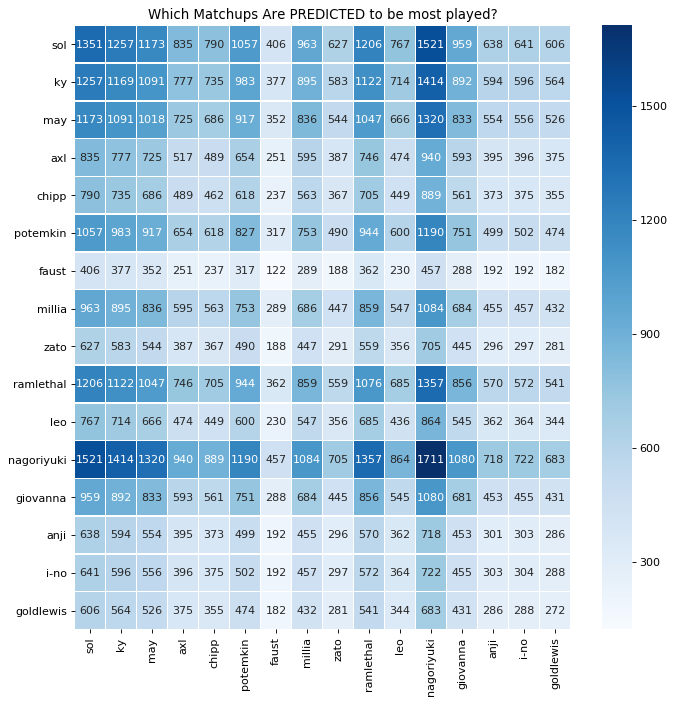

In [31]:
figure(figsize=(10, 10), dpi=80)
plt.title('Which Matchups Are PREDICTED to be most played?')
plt.show(sns.heatmap(predicted_matchup_values, linewidth=0.5,xticklabels = readable_character_names, yticklabels = readable_character_names, cmap="Blues",annot=True, fmt='g'))

0.3142857142857143 -1.0515587529976018


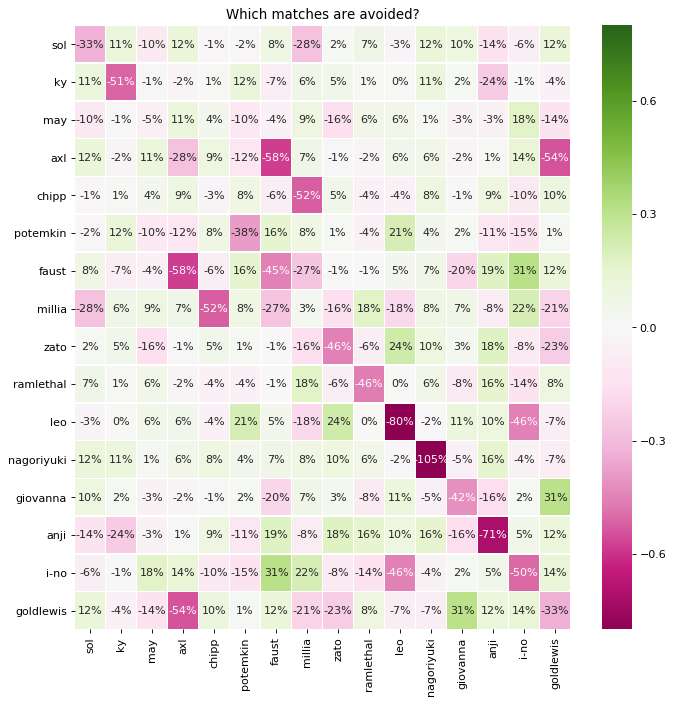

In [66]:
figure(figsize=(10, 10), dpi=80)
plt.title('Which matches are avoided?')
matchup_prediction_error = (matchup_totals - predicted_matchup_values)/matchup_totals
print(np.max(matchup_prediction_error), np.min(matchup_prediction_error))
plt.show(sns.heatmap(matchup_prediction_error, linewidth=0.5,xticklabels = readable_character_names, yticklabels = readable_character_names, cmap="PiYG",annot=True, fmt='.0%',vmin=-0.8,vmax=0.8))